In [1]:
import h2o
from h2o.automl import H2OAutoML
import json
import pickle 
import pandas as pd
import random

In [2]:
#Create a random test train split between 60-80%
n =75

#read in data, select impotant features, then split into train and test
data = pd.read_csv('/domino/datasets/local/wine-data/winequality.csv')
data['quality']= data.quality.apply(lambda x :  x * random.randrange(80,120)/100)
corr_values = data.corr().sort_values(by = 'quality')['quality'].drop('quality',axis=0)
important_feats=corr_values[abs(corr_values)>0.08]
data = data[list(important_feats.keys())+['quality']]

train = data[0:round(len(data)*n/100)]
test = data[train.shape[0]:].reset_index(drop = True)

In [3]:
print('H2O version -{}'.format(h2o.__version__))

#initailize local h2o
h2o.init()

H2O version -3.36.0.2
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp83ggbp2o
  JVM stdout: /tmp/tmp83ggbp2o/h2o_ubuntu_started_from_python.out
  JVM stderr: /tmp/tmp83ggbp2o/h2o_ubuntu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_ubuntu_3ajnre
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,976 Mb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


In [4]:
train.head()

,density,volatile acidity,chlorides,alcohol,quality
0,1.0010,0.27,0.045,8.8,6.48
1,0.9940,0.30,0.049,9.5,6.30
2,0.9951,0.28,0.050,10.1,5.58
3,0.9956,0.23,0.058,9.9,5.76
4,0.9956,0.23,0.058,9.9,6.60


In [5]:
#Convert data to h2o frames
hTrain = h2o.H2OFrame(train)
hTest = h2o.H2OFrame(test)

# Identify predictors and response
x = hTrain.columns
y = "quality"
x.remove(y)

# Isolate target vasiable
hTrain[y] = hTrain[y]
hTest[y] = hTest[y]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
%%time
# Run AutoML for 10 base models (limited to 3 min max runtime by default)
aml = H2OAutoML(max_models=10, max_runtime_secs=30, sort_metric="r2")
aml.train(x=x, y=y, training_frame=hTrain)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 720 ms, sys: 38.2 ms, total: 758 ms
Wall time: 32 s
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_1_20220307_215652


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,3.0,3.0,70798.0,20.0,20.0,20.0,1719.0,1981.0,1875.0




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1.525817056466354
RMSE: 1.2352396757173703
MAE: 0.9710448586685918
RMSLE: 0.18040649671174927
Mean Residual Deviance: 1.525817056466354

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 1.211946940851476
RMSE: 1.1008846174106877
MAE: 0.8735112504476691
RMSLE: 0.16176482750658483
Mean Residual Deviance: 1.211946940851476

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.873504,0.030336,0.901655,0.859553,0.895854,0.882855,0.827603
1,mean_residual_deviance,1.211928,0.096160,1.343108,1.146183,1.240390,1.236527,1.093431
2,mse,1.211928,0.096160,1.343108,1.146183,1.240390,1.236527,1.093431
3,r2,0.050639,0.070195,-0.061054,0.067104,0.062317,0.051569,0.133258
4,residual_deviance,1.211928,0.096160,1.343108,1.146183,1.240390,1.236527,1.093431
5,rmse,1.100183,0.043647,1.158925,1.070599,1.113728,1.111992,1.045673
6,rmsle,0.161680,0.005801,0.170713,0.159381,0.161534,0.161993,0.154780



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-03-07 21:57:15,1.637 sec,0.0,NaN,NaN,NaN
1,,2022-03-07 21:57:16,1.823 sec,3.0,1.23524,0.971045,1.525817



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,alcohol,2904.463135,1.000000,0.287379
1,density,2749.421875,0.946620,0.272039
2,volatile acidity,2287.333740,0.787524,0.226318
3,chlorides,2165.500977,0.745577,0.214263


In [7]:
aml.get_leaderboard().as_data_frame().sort_values(by = 'mse', ascending = True)

,model_id,r2,mean_residual_deviance,rmse,mse,mae,rmsle
9,StackedEnsemble_BestOfFamily_2_AutoML_1_20220303_211411,0.210877,1.001053,1.000527,1.001053,0.796178,0.147652
8,StackedEnsemble_BestOfFamily_1_AutoML_1_20220303_211411,0.205061,1.008432,1.004207,1.008432,0.799444,0.148229
7,GBM_2_AutoML_1_20220303_211411,0.188981,1.028830,1.014313,1.028830,0.806860,0.149915
6,GBM_1_AutoML_1_20220303_211411,0.186737,1.031677,1.015715,1.031677,0.808846,0.150081
5,GBM_4_AutoML_1_20220303_211411,0.178849,1.041683,1.020628,1.041683,0.813793,0.150896
4,GBM_3_AutoML_1_20220303_211411,0.178550,1.042063,1.020815,1.042063,0.812797,0.150891
3,GLM_1_AutoML_1_20220303_211411,0.151924,1.075839,1.037227,1.075839,0.823891,0.152915
2,XGBoost_2_AutoML_1_20220303_211411,0.142874,1.087320,1.042747,1.087320,0.829395,0.154049
1,XGBoost_1_AutoML_1_20220303_211411,0.121423,1.114532,1.055714,1.114532,0.834417,0.155744
0,DRF_1_AutoML_1_20220303_211411,0.000224,1.268280,1.126179,1.268280,0.885505,0.165513


In [7]:
aml.get_leaderboard().as_data_frame().sort_values(by = 'r2', ascending = False)[0:1].r2

9    0.215202
Name: r2, dtype: float64

In [8]:
import seaborn as sns
import numpy as np
import pandas as pd
best_gbm = aml.get_best_model(criterion = 'mse', algorithm = 'gbm') 
preds = best_gbm.predict(hTest)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [9]:
hTest.as_data_frame()['quality']

0       5.28
1       5.10
2       5.46
3       6.93
4       4.05
        ... 
1619    4.10
1620    4.92
1621    4.92
1622    4.45
1623    6.72
Name: quality, Length: 1624, dtype: float64

<AxesSubplot:ylabel='Count'>

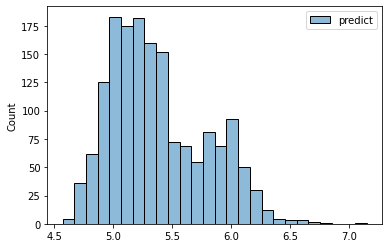

In [10]:
import seaborn as sns
sns.histplot(preds.as_data_frame())

<AxesSubplot:xlabel='quality', ylabel='Count'>

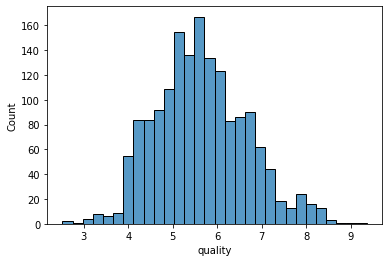

In [11]:
sns.histplot(hTest.as_data_frame()['quality'])

In [12]:
from sklearn.metrics import r2_score, mean_squared_error
#View performance metrics and save them to domino stats!
print("R2 Score: ", round(best_gbm.r2(xval=True),3))
print("MSE: ", round(best_gbm.mse(xval=True),3))

R2 Score:  0.196
MSE:  1.029


In [13]:
from sklearn.metrics import r2_score, mean_squared_error
#View performance metrics and save them to domino stats!

r2 = round(best_gbm.r2(xval=True),3)
mse = round(best_gbm.mse(xval=True),3)
print("R2 Score: ", r2)
print("MSE: ", mse)

R2 Score:  0.196
MSE:  1.029


In [14]:
results = pd.DataFrame({'Actuals':test.quality, 'Predictions': preds.as_data_frame()['predict']})

In [15]:
results

,Actuals,Predictions
0,5.28,6.025926
1,5.10,5.689201
2,5.46,5.693499
3,6.93,5.792188
4,4.05,5.148415
...,...,...
1619,4.10,5.126116
1620,4.92,5.798315
1621,4.92,5.888619
1622,4.45,5.132607


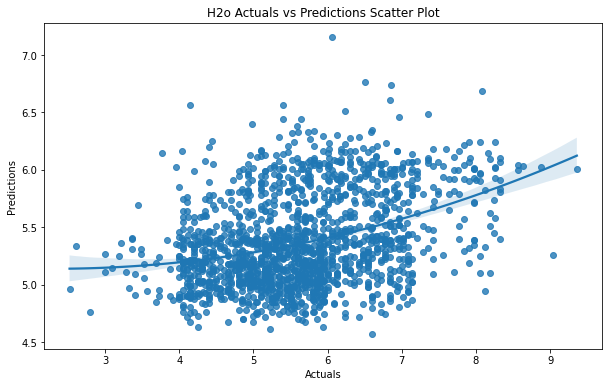

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots(figsize=(10,6))
plt.title('H2o Actuals vs Predictions Scatter Plot')
sns.regplot( 
    data=results,
    x = 'Actuals',
    y = 'Predictions',
    order = 2)
plt.savefig('/mnt/visualizations/h2o_actual_v_pred_scatter.png')

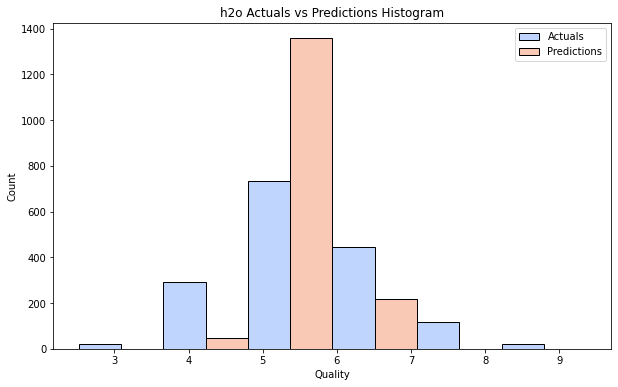

In [17]:
fig2, ax2 = plt.subplots(figsize=(10,6))
plt.title('h2o Actuals vs Predictions Histogram')
plt.xlabel('Quality')
sns.histplot(results, bins=6, multiple = 'dodge', palette = 'coolwarm')
plt.savefig('/mnt/visualizations/h2o_actual_v_pred_hist.png')

In [24]:
import pickle

h2o.save_model(best_gbm, path ='/mnt/models')
# pickle.dump(best_gbm, open(file, 'wb'))

'/mnt/models/GBM_2_AutoML_1_20220303_211411'

In [26]:
file = '/mnt/models/h2oautoml.pkl'
pickle.dump(best_gbm, open(file, 'wb'))

PicklingError: Can't pickle <class 'h2o.estimators.gbm.H2OGradientBoostingEstimator'>: it's not the same object as h2o.estimators.gbm.H2OGradientBoostingEstimator

In [31]:
pickle.load(open('/mnt/models/h2oautoml.pkl', 'rb'))

EOFError: Ran out of input

<AxesSubplot:xlabel='predict', ylabel='Count'>

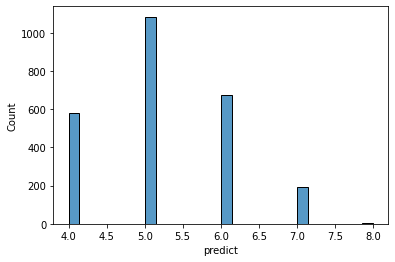

In [34]:
sns.histplot(a.as_data_frame()['predict'].apply(lambda x: np.around(x,0)))

<AxesSubplot:xlabel='predict', ylabel='Count'>

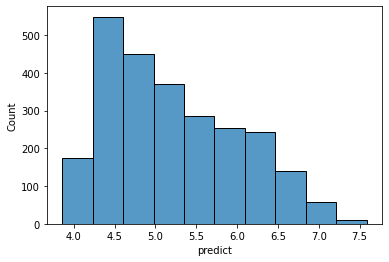

In [45]:
sns.histplot(a.as_data_frame().predict, bins = 10)

<AxesSubplot:xlabel='quality', ylabel='Count'>

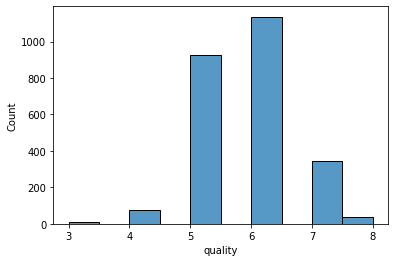

In [53]:
sns.histplot(test.quality.astype('float64'), bins =10)

In [52]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(test.quality, a.as_data_frame()['predict'])
mean_squared_error(test.quality, a.as_data_frame()['predict'])

1.0147360164977757